# Установка пакетов

In [124]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Извлечение и разделение данных

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1, L2
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
data = pd.read_csv('drive/MyDrive/Fibroids/df_after_cleaning.csv')
data

,Unnamed: 0,value_tsh,value_prl,value_lh,value_fsh,value_shbg,value_17hp,value_dheas,value_test2,value_test4,...,value_test10_bioch,value_test11_bioch,value_kd_ct,ethnicity,day_mens_prl,H_androg_all,hyperPRL,fibroids_us_2,total_testosteron,estradiol_generated
0,0,0.5,314.0,9.9,4.2,166.1,5.7,129.0,1.600,5.610,...,0.38,5.21,0.555,1.0,20.00,0.0,0.0,0.0,32.2679,0.922000
1,1,1.9,196.0,6.8,6.8,41.0,6.8,260.0,1.700,2.740,...,0.39,5.06,0.710,1.0,14.00,0.0,0.0,0.0,19.0931,0.165942
2,2,1.2,311.0,1.2,3.2,140.8,5.4,81.1,2.000,0.800,...,0.49,9.58,0.270,1.0,19.00,0.0,0.0,0.0,15.3651,0.405000
3,3,3.8,409.0,3.2,2.7,93.4,12.7,148.0,4.600,3.310,...,0.43,7.46,1.460,1.0,32.00,0.0,0.0,0.0,22.5705,0.441336
4,4,1.6,418.0,3.8,7.2,24.7,1.6,121.0,0.600,5.245,...,0.86,9.22,0.330,1.0,66.00,0.0,0.0,0.0,9.9868,0.199000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,1110,2.0,532.0,0.9,2.6,107.3,4.0,123.0,2.435,0.800,...,0.78,16.52,0.650,2.0,27.00,0.0,0.0,0.0,30.9768,0.666000
1063,1111,1.2,121.0,2.4,7.6,61.0,1.3,343.0,0.200,4.870,...,1.03,10.82,1.080,1.0,4.00,0.0,0.0,0.0,26.3261,0.107097
1064,1112,1.7,150.0,7.0,9.8,51.7,5.7,189.0,4.100,5.400,...,0.44,4.03,0.950,2.0,9.00,0.0,0.0,0.0,22.2487,0.337969
1065,1113,1.4,419.0,46.2,90.0,130.2,2.0,146.0,3.840,4.500,...,0.84,10.62,0.670,1.0,15.00,0.0,0.0,1.0,17.2901,0.241000


In [130]:
df = data.drop(['Unnamed: 0', 'ethnicity', 'day_mens_prl', 'H_androg_all', 'hyperPRL'], axis=1)

Отделение 200 записей для формирования несбалансированной тестовой выборки

In [131]:
X = df.iloc[:-200].drop(['fibroids_us_2'], axis=1)
y = df.iloc[:-200]['fibroids_us_2']

In [132]:
y.value_counts()

0.0    725
1.0    142
Name: fibroids_us_2, dtype: int64

In [133]:
X_test = df.iloc[-200:].drop(['fibroids_us_2'], axis=1)
y_test = df.iloc[-200:]['fibroids_us_2']

In [134]:
y_test.value_counts()

0.0    185
1.0     15
Name: fibroids_us_2, dtype: int64

# Балансировка данных

In [135]:
oversample = SMOTE(random_state=10)
X, y = oversample.fit_resample(X, y)

In [136]:
y.value_counts()

0.0    725
1.0    725
Name: fibroids_us_2, dtype: int64

# Построение моделей

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [138]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

## Логистическая регрессия

In [139]:
log_reg = LogisticRegression(max_iter=5000, random_state=0)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=0)

In [140]:
y_pred = log_reg.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.6206896551724138
F1 Score: 0.5955882352941176
Precision: 0.6328125
Recall: 0.5625
[[99 47]
 [63 81]]


In [141]:
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.63
F1 Score: 0.19565217391304346
Precision: 0.11688311688311688
Recall: 0.6
[[117  68]
 [  6   9]]


## Дерево решений

In [142]:
dtc = DecisionTreeClassifier(random_state=0)

dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [143]:
y_pred = dtc.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.7896551724137931
F1 Score: 0.7889273356401383
Precision: 0.7862068965517242
Recall: 0.7916666666666666
[[115  31]
 [ 30 114]]


In [144]:
y_pred = dtc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7
F1 Score: 0.23076923076923073
Precision: 0.14285714285714285
Recall: 0.6
[[131  54]
 [  6   9]]


## XGBoost

In [145]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [146]:
y_pred = xgb.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.9137931034482759
F1 Score: 0.9163879598662208
Precision: 0.8838709677419355
Recall: 0.9513888888888888
[[128  18]
 [  7 137]]


In [147]:
y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8
F1 Score: 0.13043478260869568
Precision: 0.0967741935483871
Recall: 0.2
[[157  28]
 [ 12   3]]


In [148]:
# предсказание вероятности
print(xgb.predict_proba(pd.DataFrame(X_train.loc[5]).T)) #1
print(xgb.predict_proba(pd.DataFrame(X_train.loc[6]).T)) #0

[[0.00975275 0.99024725]]
[[0.965153   0.03484702]]


## Объяснение результатов XGBoost с использованием SHAP

In [149]:
import shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


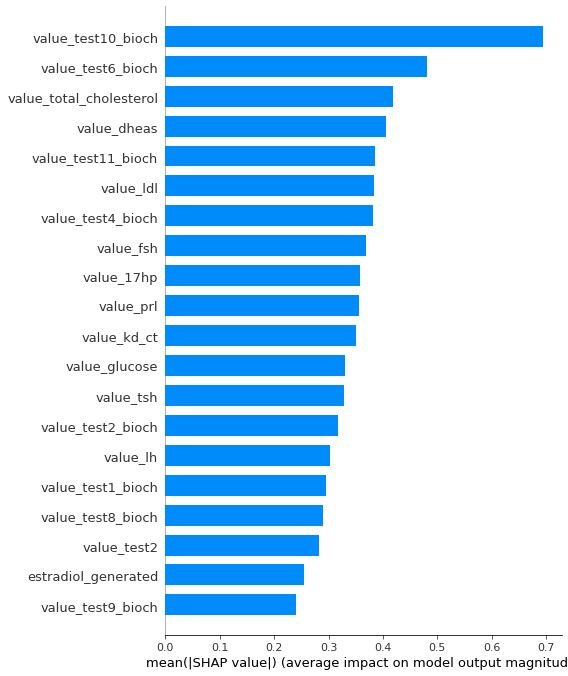

In [150]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


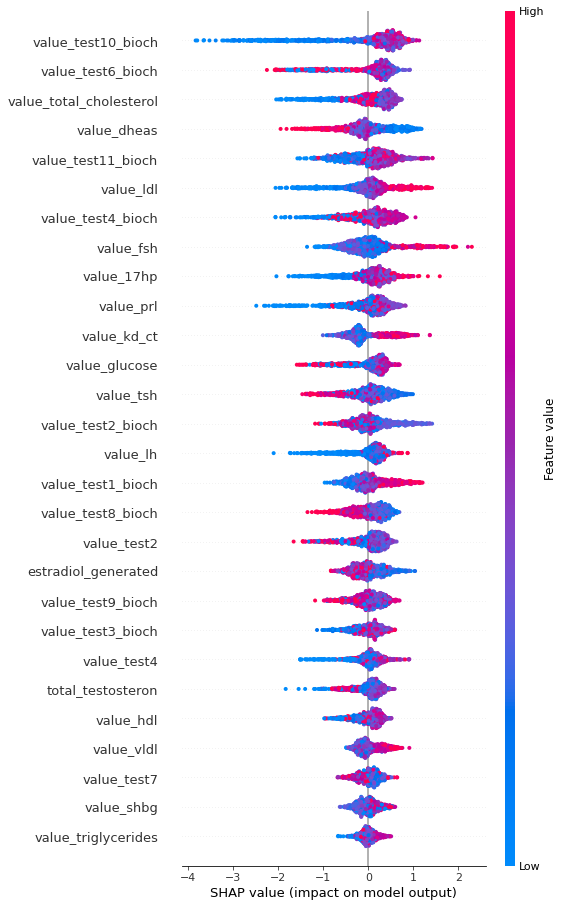

In [151]:
shap.summary_plot(shap_values, X_train, max_display=35, auto_size_plot=True)

In [152]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(xgb).expected_value, shap_values[0,:], X_train.loc[5]) #для пациента с заболеванием

## Нейронная сеть с набором всех признаков

In [153]:
X = df.drop(['fibroids_us_2'], axis=1)
y = df['fibroids_us_2']

Балансировка

In [154]:
oversample = SMOTE(random_state=0)
X, y = oversample.fit_resample(X, y)

In [155]:
y.value_counts()

0.0    910
1.0    910
Name: fibroids_us_2, dtype: int64

Нормализация

In [156]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Epoch 1/40
73/73 [==============================] - 8s 19ms/step - loss: 0.9098 - val_loss: 0.7561
Epoch 2/40
73/73 [==============================] - 1s 11ms/step - loss: 0.7574 - val_loss: 0.7383
Epoch 3/40
73/73 [==============================] - 1s 15ms/step - loss: 0.7110 - val_loss: 0.7245
Epoch 4/40
73/73 [==============================] - 1s 15ms/step - loss: 0.6945 - val_loss: 0.7191
Epoch 5/40
73/73 [==============================] - 1s 19ms/step - loss: 0.6528 - val_loss: 0.7142
Epoch 6/40
73/73 [==============================] - 1s 14ms/step - loss: 0.6621 - val_loss: 0.6725
Epoch 7/40
73/73 [==============================] - 1s 16ms/step - loss: 0.6092 - val_loss: 0.6448
Epoch 8/40
73/73 [==============================] - 1s 10ms/step - loss: 0.6071 - val_loss: 0.6132
Epoch 9/40
73/73 [==============================] - 1s 8ms/step - loss: 0.6055 - val_loss: 0.5807
Epoch 10/40
73/73 [==============================] - 1s 8ms/step - loss: 0.5912 - val_loss: 0.5664
Epoch 11/40

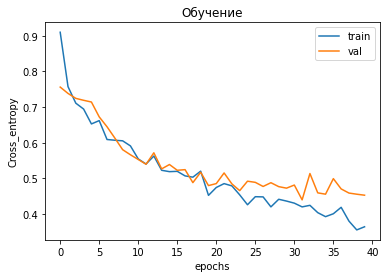

In [158]:
n_features = X.shape[1]
model = Sequential()
#слои
model.add(Dense(50, activation='relu', input_shape=(n_features,), activity_regularizer=L2(0.1) ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
#Компилируем модель
model.compile(optimizer='adam', loss = 'binary_crossentropy')
#обучение модели
history = model.fit(X_train, y_train,
                    epochs = 40,
                    batch_size=20,
                    verbose = 1,
                    validation_data = (X_test, y_test))
#predict test_set
yhat = (model.predict(X_test) > 0.5).astype("int32")

#Validation
score = accuracy_score(y_test, yhat)
print('Accuracy', score)
print(confusion_matrix(y_test, yhat))

#визуализаия процесса обучения по х эпохи, а по у ошибка(бинарная кроссэнтропия)
plt.title('Обучение')
plt.xlabel('epochs')
plt.ylabel('Сross_entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'val')
plt.legend()
plt.show()

In [159]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 50)                1450      
                                                                 
 batch_normalization_6 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_72 (Dense)            (None, 20)                1020      
                                                                 
 batch_normalization_7 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 20)              

In [160]:
y_pred_proba = model.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred_proba]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

12/12 [==============================] - 0s 2ms/step
0.7884615384615384
[[117  59]
 [ 18 170]]


In [161]:
model.get_weights()[0][0]

array([ 5.0448582e-02, -1.1179717e-01,  4.1047944e-04, -2.8642169e-01,
        4.3251127e-01,  3.8095051e-01,  6.7500379e-03, -1.6765153e-01,
       -7.4232087e-02, -1.3543761e-01,  1.5606453e-01, -1.3544343e-01,
        7.4987441e-02, -2.2516130e-01, -2.6058212e-01,  1.5443753e-01,
       -3.2123730e-02,  3.2969454e-01, -2.6721010e-01, -4.9264073e-02,
       -1.6642486e-01, -1.4802200e-02,  1.9136283e-01,  2.8704038e-01,
       -2.3923904e-02, -2.6089802e-01,  4.6726372e-02,  8.6636983e-02,
       -1.3012323e-01,  3.8068435e-01,  2.0010550e-01, -1.3505740e-02,
       -1.3330097e-01,  1.5323184e-02,  9.6428737e-02,  8.9318961e-02,
        3.1096670e-01, -2.2319072e-01, -2.3011231e-01,  1.7699325e-01,
        4.5475359e-03,  1.3697104e-01, -2.5629729e-01, -1.2612511e-01,
       -2.0565563e-01, -1.5744299e-02,  1.2055801e-02, -3.0197346e-01,
        3.0183909e-02,  3.1936333e-01], dtype=float32)

Epoch 1/27
82/82 [==============================] - 1s 5ms/step - loss: 0.6919 - val_loss: 0.6851
Epoch 2/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6794 - val_loss: 0.6728
Epoch 3/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6694 - val_loss: 0.6609
Epoch 4/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6596 - val_loss: 0.6545
Epoch 5/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6493 - val_loss: 0.6479
Epoch 6/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6410 - val_loss: 0.6480
Epoch 7/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6337 - val_loss: 0.6453
Epoch 8/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6284 - val_loss: 0.6415
Epoch 9/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6191 - val_loss: 0.6422
Epoch 10/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6130 - val_loss: 0.6442
Epoch 11/27
82/82 [

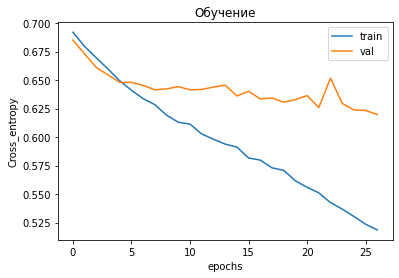

Средняя точность при кросс валидации 0.6208791208791209
Epoch 1/27
82/82 [==============================] - 3s 9ms/step - loss: 0.6911 - val_loss: 0.6920
Epoch 2/27
82/82 [==============================] - 0s 6ms/step - loss: 0.6874 - val_loss: 0.6875
Epoch 3/27
82/82 [==============================] - 1s 8ms/step - loss: 0.6808 - val_loss: 0.6844
Epoch 4/27
82/82 [==============================] - 1s 9ms/step - loss: 0.6696 - val_loss: 0.6812
Epoch 5/27
82/82 [==============================] - 1s 9ms/step - loss: 0.6571 - val_loss: 0.6780
Epoch 6/27
82/82 [==============================] - 1s 9ms/step - loss: 0.6449 - val_loss: 0.6778
Epoch 7/27
82/82 [==============================] - 1s 11ms/step - loss: 0.6312 - val_loss: 0.6785
Epoch 8/27
82/82 [==============================] - 1s 8ms/step - loss: 0.6187 - val_loss: 0.6808
Epoch 9/27
82/82 [==============================] - 1s 9ms/step - loss: 0.6096 - val_loss: 0.6833
Epoch 10/27
82/82 [==============================] - 0s 6ms/s

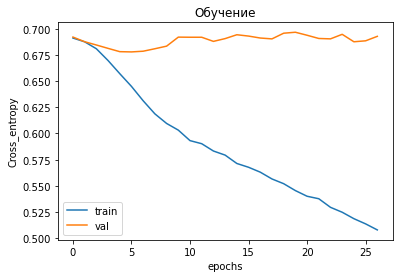

Средняя точность при кросс валидации 0.6373626373626373
Epoch 1/27
82/82 [==============================] - 2s 6ms/step - loss: 0.7047 - val_loss: 0.6929
Epoch 2/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6856 - val_loss: 0.6842
Epoch 3/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6748 - val_loss: 0.6752
Epoch 4/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6626 - val_loss: 0.6673
Epoch 5/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6535 - val_loss: 0.6592
Epoch 6/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6439 - val_loss: 0.6538
Epoch 7/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6341 - val_loss: 0.6488
Epoch 8/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6283 - val_loss: 0.6416
Epoch 9/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6204 - val_loss: 0.6387
Epoch 10/27
82/82 [==============================] - 0s 4ms/st

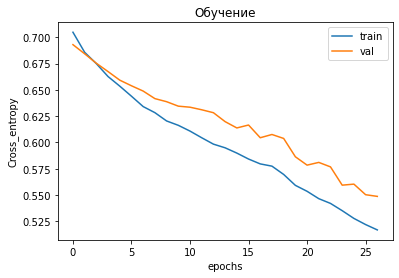

Средняя точность при кросс валидации 0.6575091575091575
Epoch 1/27
82/82 [==============================] - 2s 12ms/step - loss: 0.6897 - val_loss: 0.6842
Epoch 2/27
82/82 [==============================] - 1s 8ms/step - loss: 0.6760 - val_loss: 0.6768
Epoch 3/27
82/82 [==============================] - 1s 7ms/step - loss: 0.6617 - val_loss: 0.6674
Epoch 4/27
82/82 [==============================] - 0s 5ms/step - loss: 0.6497 - val_loss: 0.6596
Epoch 5/27
82/82 [==============================] - 0s 6ms/step - loss: 0.6361 - val_loss: 0.6529
Epoch 6/27
82/82 [==============================] - 0s 5ms/step - loss: 0.6260 - val_loss: 0.6455
Epoch 7/27
82/82 [==============================] - 0s 5ms/step - loss: 0.6173 - val_loss: 0.6321
Epoch 8/27
82/82 [==============================] - 0s 5ms/step - loss: 0.6078 - val_loss: 0.6262
Epoch 9/27
82/82 [==============================] - 1s 7ms/step - loss: 0.6026 - val_loss: 0.6169
Epoch 10/27
82/82 [==============================] - 1s 14ms/

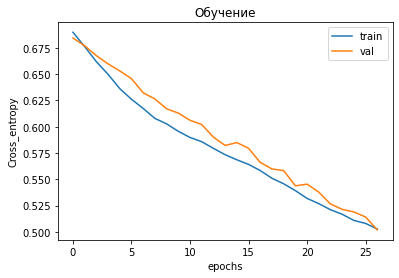

Средняя точность при кросс валидации 0.6909340659340659
Epoch 1/27
82/82 [==============================] - 2s 7ms/step - loss: 0.6831 - val_loss: 0.6753
Epoch 2/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6657 - val_loss: 0.6660
Epoch 3/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6542 - val_loss: 0.6532
Epoch 4/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6427 - val_loss: 0.6444
Epoch 5/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6304 - val_loss: 0.6463
Epoch 6/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6212 - val_loss: 0.6322
Epoch 7/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6131 - val_loss: 0.6311
Epoch 8/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6029 - val_loss: 0.6310
Epoch 9/27
82/82 [==============================] - 0s 3ms/step - loss: 0.5973 - val_loss: 0.6180
Epoch 10/27
82/82 [==============================] - 0s 3ms/st

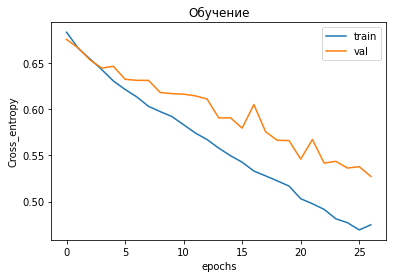

Средняя точность при кросс валидации 0.6956043956043956
Epoch 1/27
82/82 [==============================] - 4s 22ms/step - loss: 0.6886 - val_loss: 0.6828
Epoch 2/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6814 - val_loss: 0.6689
Epoch 3/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6746 - val_loss: 0.6603
Epoch 4/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6656 - val_loss: 0.6450
Epoch 5/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6574 - val_loss: 0.6327
Epoch 6/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6498 - val_loss: 0.6200
Epoch 7/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6414 - val_loss: 0.6084
Epoch 8/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6360 - val_loss: 0.5961
Epoch 9/27
82/82 [==============================] - 0s 2ms/step - loss: 0.6285 - val_loss: 0.5874
Epoch 10/27
82/82 [==============================] - 0s 3ms/s

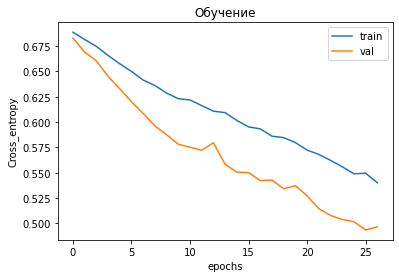

Средняя точность при кросс валидации 0.706959706959707
Epoch 1/27
82/82 [==============================] - 2s 7ms/step - loss: 0.6901 - val_loss: 0.6862
Epoch 2/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6800 - val_loss: 0.6789
Epoch 3/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6723 - val_loss: 0.6731
Epoch 4/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6627 - val_loss: 0.6650
Epoch 5/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6540 - val_loss: 0.6580
Epoch 6/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6440 - val_loss: 0.6486
Epoch 7/27
82/82 [==============================] - 0s 4ms/step - loss: 0.6325 - val_loss: 0.6457
Epoch 8/27
82/82 [==============================] - 1s 10ms/step - loss: 0.6200 - val_loss: 0.6324
Epoch 9/27
82/82 [==============================] - 1s 14ms/step - loss: 0.6134 - val_loss: 0.6231
Epoch 10/27
82/82 [==============================] - 1s 10ms/

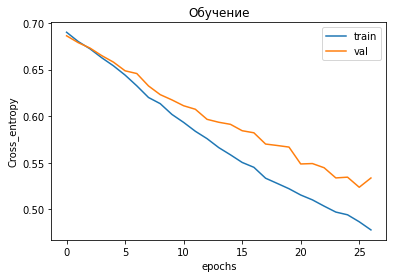

Средняя точность при кросс валидации 0.7080062794348508
Epoch 1/27
82/82 [==============================] - 2s 5ms/step - loss: 0.6936 - val_loss: 0.6861
Epoch 2/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6756 - val_loss: 0.6726
Epoch 3/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6615 - val_loss: 0.6692
Epoch 4/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6466 - val_loss: 0.6522
Epoch 5/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6330 - val_loss: 0.6456
Epoch 6/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6253 - val_loss: 0.6405
Epoch 7/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6192 - val_loss: 0.6365
Epoch 8/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6153 - val_loss: 0.6379
Epoch 9/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6114 - val_loss: 0.6287
Epoch 10/27
82/82 [==============================] - 0s 3ms/st

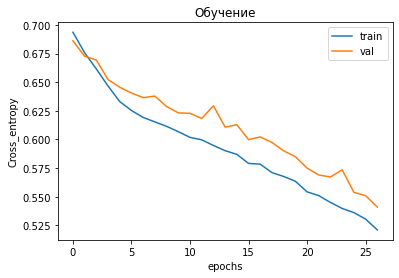

Средняя точность при кросс валидации 0.7156593406593407
Epoch 1/27
82/82 [==============================] - 1s 5ms/step - loss: 0.6921 - val_loss: 0.6881
Epoch 2/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6799 - val_loss: 0.6761
Epoch 3/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6692 - val_loss: 0.6559
Epoch 4/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6536 - val_loss: 0.6301
Epoch 5/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6375 - val_loss: 0.6186
Epoch 6/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6230 - val_loss: 0.5856
Epoch 7/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6138 - val_loss: 0.5942
Epoch 8/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6018 - val_loss: 0.5753
Epoch 9/27
82/82 [==============================] - 0s 3ms/step - loss: 0.5893 - val_loss: 0.5501
Epoch 10/27
82/82 [==============================] - 0s 3ms/st

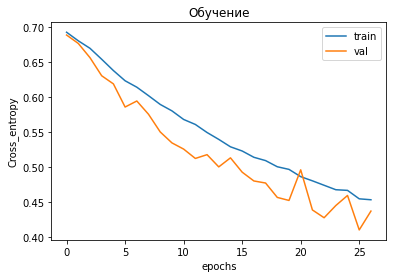

Средняя точность при кросс валидации 0.7271062271062271
Epoch 1/27
82/82 [==============================] - 2s 7ms/step - loss: 0.6940 - val_loss: 0.6872
Epoch 2/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6667 - val_loss: 0.6845
Epoch 3/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6547 - val_loss: 0.6737
Epoch 4/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6426 - val_loss: 0.6645
Epoch 5/27
82/82 [==============================] - 0s 2ms/step - loss: 0.6300 - val_loss: 0.6776
Epoch 6/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6185 - val_loss: 0.6532
Epoch 7/27
82/82 [==============================] - 0s 3ms/step - loss: 0.6079 - val_loss: 0.6497
Epoch 8/27
82/82 [==============================] - 0s 3ms/step - loss: 0.5995 - val_loss: 0.6538
Epoch 9/27
82/82 [==============================] - 0s 3ms/step - loss: 0.5873 - val_loss: 0.6391
Epoch 10/27
82/82 [==============================] - 0s 3ms/st

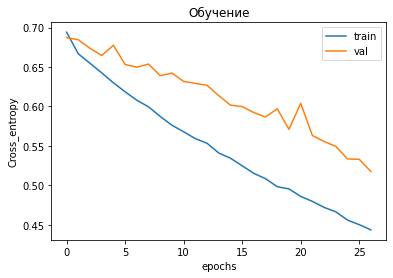

Средняя точность при кросс валидации 0.7318681318681318


In [162]:
###Кросс-валидация
k_fold = StratifiedKFold(10)
scores = [] #список для метрик
for train_ix, test_ix in k_fold.split(X,y):
    X_train, X_test, y_train, y_test = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
    n_features = X.shape[1]
    model = Sequential()
    #слои
    model.add(Dense(20, activation='relu', input_shape=(n_features,) ))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #Компилируем модель
    model.compile(optimizer='adam', loss = 'binary_crossentropy')
    #обучение модели
    history = model.fit(X_train, y_train,
                        epochs = 27,
                        batch_size=20,
                        verbose = 1,
                        validation_data = (X_test, y_test))
    #predict test_set
    yhat = (model.predict(X_test) > 0.5).astype("int32")

    #Validation
    score = accuracy_score(y_test, yhat)
    print('Accuracy', score)
    print(confusion_matrix(y_test, yhat))

    #визуализаия процесса обучения по х эпохи, а по у ошибка(бинарная кроссэнтропия)
    plt.title('Обучение')
    plt.xlabel('epochs')
    plt.ylabel('Сross_entropy')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label = 'val')
    plt.legend()
    plt.show()
    
    scores.append(score)
    print('Средняя точность при кросс валидации', (np.mean(scores)))